这篇论文用了比较简单的方法。
- http://ceur-ws.org/Vol-1094/bioasq2013_submission_8.pdf

我们的思路可以类似：
1. 拆分成10个问题。分别做feature的score
2. 对feature score取最大值或者平均值，作为feature在multi-label情况下的score
3. 选择出对于10个label来说，最关联的几个feature。

In [1]:
%pylab inline
%matplotlib inline
from sklearn import cross_validation
import pandas as pd
store = pd.HDFStore('store.h5')

Populating the interactive namespace from numpy and matplotlib


In [2]:
store

<class 'pandas.io.pytables.HDFStore'>
File path: store.h5
/data                             frame        (shape->[1000,9443]) 
/feature_score                    series       (shape->[28329])     
/feature_selected_data            frame        (shape->[1000,3243]) 
/gene_info                        frame        (shape->[300,9443])  
/label                            frame        (shape->[1000,1])    
/multilabel                       frame        (shape->[1000,10])   
/onehot_data                      frame        (shape->[1000,28329])
/selected_idx                     series       (shape->[28329])     

(1000, 28329) (1000,)


(array([ 500.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  500.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

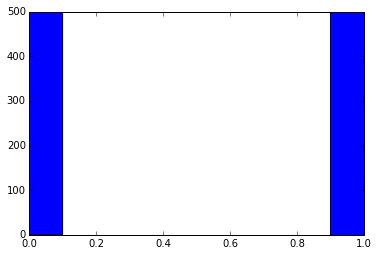

In [5]:
X = store['onehot_data']
y = store['multilabel'][0].as_matrix()
print X.shape, y.shape
hist(y)

分别对10个label使用 stability selection的方法，计算feature的score。

In [10]:
%%time
from sklearn.linear_model import RandomizedLogisticRegression
scores = []
for i in range(10):
    y = store['multilabel'][i].as_matrix()
    print 'label ',i
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', DeprecationWarning)
        clf = RandomizedLogisticRegression().fit(X,y)
    scores.append(clf.scores_)
scores_df = pd.DataFrame(scores)

label  0
label  1
label  2
label  3
label  4
label  5
label  6
label  7
label  8
label  9
CPU times: user 40min 43s, sys: 11min 12s, total: 51min 56s
Wall time: 1h 43min 35s


In [12]:
scores_df

,0,1,2,3,4,5,6,7,8,9,...,28319,28320,28321,28322,28323,28324,28325,28326,28327,28328
0,0.015,0,0.000,0.000,0,0.000,0,0,0,0.045,...,0,0.00,0.000,0.000,0,0.005,0,0.005,0,0
1,0.000,0,0.005,0.045,0,0.000,0,0,0,0.000,...,0,0.00,0.010,0.000,0,0.000,0,0.000,0,0
2,0.025,0,0.005,0.020,0,0.010,0,0,0,0.025,...,0,0.01,0.095,0.000,0,0.000,0,0.000,0,0
3,0.005,0,0.000,0.000,0,0.000,0,0,0,0.010,...,0,0.00,0.000,0.000,0,0.000,0,0.000,0,0
4,0.000,0,0.000,0.020,0,0.005,0,0,0,0.000,...,0,0.00,0.005,0.010,0,0.000,0,0.000,0,0
5,0.000,0,0.015,0.000,0,0.000,0,0,0,0.005,...,0,0.00,0.000,0.000,0,0.000,0,0.000,0,0
6,0.000,0,0.010,0.000,0,0.010,0,0,0,0.120,...,0,0.00,0.000,0.005,0,0.000,0,0.000,0,0
7,0.000,0,0.005,0.000,0,0.000,0,0,0,0.045,...,0,0.00,0.000,0.000,0,0.000,0,0.000,0,0
8,0.005,0,0.040,0.000,0,0.000,0,0,0,0.005,...,0,0.00,0.015,0.000,0,0.000,0,0.000,0,0
9,0.000,0,0.045,0.030,0,0.000,0,0,0,0.010,...,0,0.00,0.005,0.000,0,0.000,0,0.000,0,0


In [14]:
store['multilabel-feat-importance']=scores_df
store.flush()

In [16]:
weidian_imp = pd.DataFrame()
for i in range(scores_df.shape[1]/3):
    weidian_imp[i] = scores_df[3*i]+scores_df[3*i+1]+scores_df[3*i+2]
weidian_imp 

,0,1,2,3,4,5,6,7,8,9,...,9433,9434,9435,9436,9437,9438,9439,9440,9441,9442
0,0.015,0.000,0,0.050,0,0.005,0.015,0.00,0,0.005,...,0.010,0,0.01,0.000,0.005,0.010,0.00,0.000,0.005,0.005
1,0.005,0.045,0,0.005,0,0.015,0.005,0.00,0,0.070,...,0.000,0,0.00,0.005,0.000,0.000,0.00,0.010,0.000,0.000
2,0.030,0.030,0,0.025,0,0.115,0.010,0.00,0,0.015,...,0.000,0,0.00,0.000,0.000,0.000,0.00,0.105,0.000,0.000
3,0.005,0.000,0,0.140,0,0.000,0.000,0.00,0,0.005,...,0.035,0,0.00,0.010,0.000,0.000,0.00,0.000,0.000,0.000
4,0.000,0.025,0,0.055,0,0.000,0.000,0.00,0,0.000,...,0.000,0,0.00,0.000,0.000,0.020,0.00,0.015,0.000,0.000
5,0.015,0.000,0,0.005,0,0.030,0.000,0.00,0,0.010,...,0.005,0,0.00,0.075,0.000,0.000,0.00,0.000,0.000,0.000
6,0.010,0.010,0,0.155,0,0.020,0.050,0.01,0,0.010,...,0.000,0,0.00,0.000,0.000,0.010,0.00,0.005,0.000,0.000
7,0.005,0.000,0,0.235,0,0.000,0.000,0.00,0,0.030,...,0.000,0,0.00,0.050,0.000,0.000,0.01,0.000,0.000,0.000
8,0.045,0.000,0,0.070,0,0.010,0.000,0.00,0,0.225,...,0.000,0,0.00,0.005,0.000,0.005,0.00,0.015,0.000,0.000
9,0.045,0.030,0,0.035,0,0.015,0.005,0.00,0,0.215,...,0.000,0,0.00,0.015,0.000,0.000,0.01,0.005,0.000,0.000


In [18]:
simp = sum(weidian_imp,axis=1)
print simp
for i in range(10):
    weidian_imp.iloc[i,:]=weidian_imp.iloc[i,:]/simp[i]
print sum(weidian_imp,axis=1)

0    105.230
1    105.205
2    105.960
3    102.815
4    103.990
5    104.180
6    104.165
7    104.380
8    102.530
9    105.105
dtype: float64
0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
dtype: float64


In [20]:
weidian_imp

,0,1,2,3,4,5,6,7,8,9,...,9433,9434,9435,9436,9437,9438,9439,9440,9441,9442
0,0.000143,0.000000,0,0.000475,0,0.000048,0.000143,0.000000,0,0.000048,...,0.000095,0,0.000095,0.000000,0.000048,0.000095,0.000000,0.000000,0.000048,0.000048
1,0.000048,0.000428,0,0.000048,0,0.000143,0.000048,0.000000,0,0.000665,...,0.000000,0,0.000000,0.000048,0.000000,0.000000,0.000000,0.000095,0.000000,0.000000
2,0.000283,0.000283,0,0.000236,0,0.001085,0.000094,0.000000,0,0.000142,...,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000991,0.000000,0.000000
3,0.000049,0.000000,0,0.001362,0,0.000000,0.000000,0.000000,0,0.000049,...,0.000340,0,0.000000,0.000097,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000240,0,0.000529,0,0.000000,0.000000,0.000000,0,0.000000,...,0.000000,0,0.000000,0.000000,0.000000,0.000192,0.000000,0.000144,0.000000,0.000000
5,0.000144,0.000000,0,0.000048,0,0.000288,0.000000,0.000000,0,0.000096,...,0.000048,0,0.000000,0.000720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000096,0.000096,0,0.001488,0,0.000192,0.000480,0.000096,0,0.000096,...,0.000000,0,0.000000,0.000000,0.000000,0.000096,0.000000,0.000048,0.000000,0.000000
7,0.000048,0.000000,0,0.002251,0,0.000000,0.000000,0.000000,0,0.000287,...,0.000000,0,0.000000,0.000479,0.000000,0.000000,0.000096,0.000000,0.000000,0.000000
8,0.000439,0.000000,0,0.000683,0,0.000098,0.000000,0.000000,0,0.002194,...,0.000000,0,0.000000,0.000049,0.000000,0.000049,0.000000,0.000146,0.000000,0.000000
9,0.000428,0.000285,0,0.000333,0,0.000143,0.000048,0.000000,0,0.002046,...,0.000000,0,0.000000,0.000143,0.000000,0.000000,0.000095,0.000048,0.000000,0.000000


两个方案，计算max或计算average

In [24]:
weidian_imp_max = np.max(weidian_imp)
weidian_imp_mean = mean(weidian_imp)

weidian_imp_max_idx = np.argsort(weidian_imp_max)[::-1]
weidian_imp_mean_idx = np.argsort(weidian_imp_mean)[::-1]

print weidian_imp_max.shape, weidian_imp_mean.shape

(9443,) (9443,)


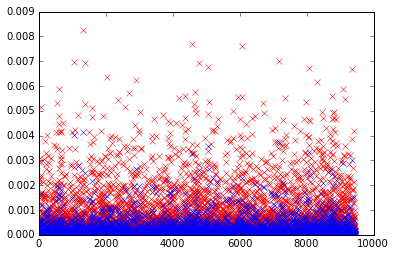

In [28]:
plot(weidian_imp_max,'rx',weidian_imp_mean,'bx')

<Container object of 100 artists>

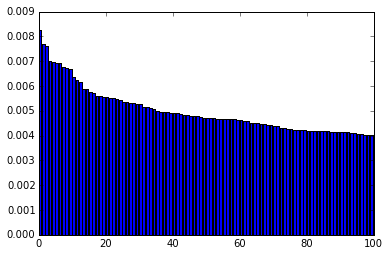

In [35]:
N=100
bar(range(N),weidian_imp_max[weidian_imp_max_idx][0:N])

<Container object of 100 artists>

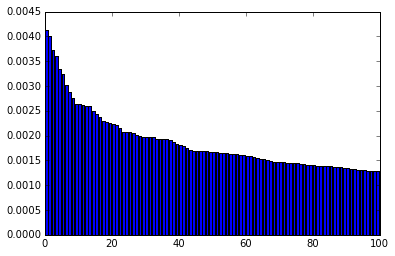

In [36]:
N=100
bar(range(N),weidian_imp_mean[weidian_imp_mean_idx][0:N])

In [41]:
print weidian_imp_mean_idx.as_matrix().T[0:15]
print weidian_imp_max_idx.as_matrix().T[0:15]

[1338 1049 7179 5064 8062 4568 9371 9094 1166 5091 2907 4785 8706 8060 1368]
[1338 4568 6075 7179 1049 4785 1368 5064 8062 9371 2045 2907 8308  608 9094]
